Encoder Decoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.4 Code

In [ ]:
## Imports
import os
import sys
import random


import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".jpg"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)

        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = np.zeros((self.image_size, self.image_size, 1))

        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)

        ## Normalizing
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(32, 640, 640, 3) (32, 640, 640, 1)


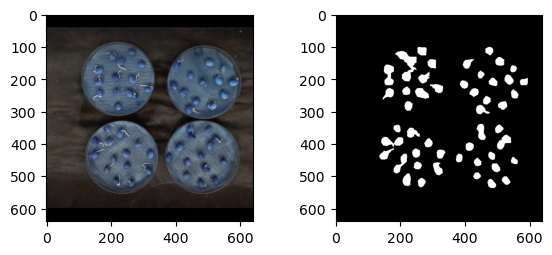

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)

ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

## UNet Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the basic CNN model
def basic_cnn_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    inputs = tf.keras.layers.Input(shape=input_shape)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D()(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D()(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    pool3 = tf.keras.layers.MaxPooling2D()(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    pool4 = tf.keras.layers.MaxPooling2D()(conv4)

    # Center block (5th layer)
    center = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)

    # Decoder
    up5 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), activation='relu', padding='same')(center)
    concat5 = tf.keras.layers.concatenate([conv4, up5], axis=-1)
    conv5 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(concat5)

    up6 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([conv3, up6], axis=-1)
    conv6 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(concat6)

    up7 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([conv2, up7], axis=-1)
    conv7 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat7)

    up8 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', padding='same')(conv7)
    concat8 = tf.keras.layers.concatenate([conv1, up8], axis=-1)
    conv8 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat8)

    # Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(conv8)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

# Example usage



In [ ]:
input_shape = (640, 640, 3)  # Replace with your input image shape
num_classes = 2 # Binary segmentation: Seed or background
model = basic_cnn_model(input_shape, num_classes)

# Print model summary
# model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 640, 640, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 320, 320, 64  0           ['conv2d[0][0]']                 
                                )                                                             

## Training the model

In [ ]:
from tensorflow.keras.callbacks import TensorBoard


train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

tensorboard_callback = TensorBoard(log_dir='C:/Users/NIT/Downloads/Log/Log1', histogram_freq=1)


model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=50)

C:\Users\NIT\AppData\Local\Temp\ipykernel_1444\3046209608.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,


Epoch 1/50
15/15 [==============================] - 962s 61s/step - loss: 0.4866 - acc: 0.5992 - val_loss: 0.2952 - val_acc: 0.9129
Epoch 2/50
15/15 [==============================] - 743s 49s/step - loss: 0.2335 - acc: 0.6595 - val_loss: 0.1885 - val_acc: 0.0996
Epoch 3/50
15/15 [==============================] - 825s 54s/step - loss: 0.1861 - acc: 0.3643 - val_loss: 0.1720 - val_acc: 0.7132
Epoch 4/50
15/15 [==============================] - 877s 58s/step - loss: 0.1824 - acc: 0.6042 - val_loss: 0.1580 - val_acc: 0.2371
Epoch 5/50
15/15 [==============================] - 848s 56s/step - loss: 0.1610 - acc: 0.6654 - val_loss: 0.1415 - val_acc: 0.8761
Epoch 6/50
15/15 [==============================] - 884s 59s/step - loss: 0.1451 - acc: 0.3983 - val_loss: 0.1357 - val_acc: 0.2072
Epoch 7/50
15/15 [==============================] - 954s 63s/step - loss: 0.1365 - acc: 0.7608 - val_loss: 0.1318 - val_acc: 0.5585
Epoch 8/50
15/15 [==============================] - 850s 57s/step - loss: 0.

### **Final Result**

1/1 [==============================] - 12s 12s/step


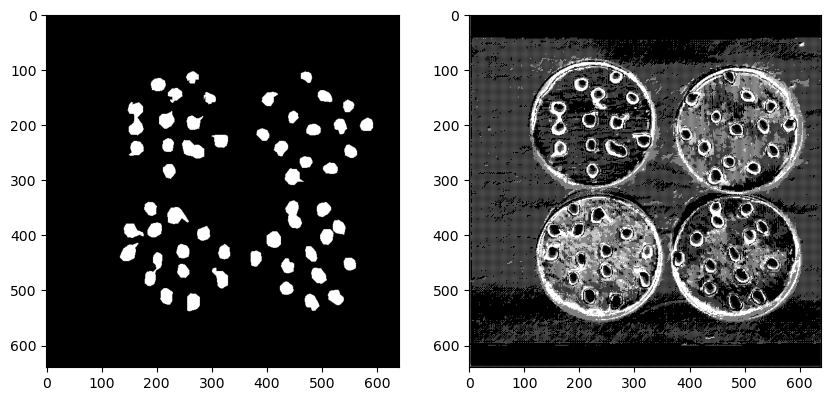

In [ ]:

model.save_weights("EncoderDecoderHW.h5")
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)


x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5
result_foreground = (result[:, :, :, 0] * 255).astype(np.uint8)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(result_foreground[0], cmap="gray")

plt.show()